In [25]:
import spacy
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
nlp = spacy.load('de_core_news_sm')
import re
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

linebreak_pattern_1 = re.compile(r"-\n\d+\n", re.DOTALL)
linebreak_pattern_2 = re.compile(r"-\n", re.DOTALL)
space_pattern = re.compile(r"\n|\x0c|\x07|\x08|\xad|\xa0|\u200a|\t|\.|\,|\/", re.DOTALL)
word_pattern = re.compile(r"[a-zA-Z üäößÜÖÄ]", re.DOTALL)
whitespace_pattern = re.compile(r"\s+")

political_vocabulary = [
    'frei',
    'gleich',
    'solidar',
    'sozial',
    'privatisier',
    'leistung',
    'heimat',
    'mitbestimm',
    'nachhaltig',
    'umwelt',
    'armut',
    'diskriminier',
    'demokratisier',
    'digital',
    'klimawandel',
]

parties = [
    'linke',
    'grüne',
    'spd',
    'fdp',
    'cdu_csu',
    'afd',
]

media = [
    'junge Welt',
    "NachDenkSeiten",
    'taz',
    'Süddeutsche Zeitung',
    'stern TV',
    "DER SPIEGEL",
    'ZEIT ONLINE',
    'Der Tagesspiegel',
    'ARD',
    #'Tagesschau',
    'ZDF',
    "ZDFheute Nachrichten",
    'Bayerischer Rundfunk',
    'ntv Nachrichten',
    'RTL',
    'FOCUS Online',
    'faz',
    'WELT',
    "BILD",
    'NZZ Neue Zürcher Zeitung',
    "Junge Freiheit",
    'COMPACTTV'
]

In [2]:
def extract_party_phrase_counts(party):
    with open(f"../assets/manifests/{party}_manifest.txt", encoding="utf-8", errors="ignore") as d:
        manifest = d.read()
    manifest = re.sub(linebreak_pattern_1, "", manifest)
    manifest = re.sub(linebreak_pattern_2, "", manifest)
    manifest = re.sub(space_pattern, " ", manifest)
    manifest = "".join(re.findall(word_pattern, manifest))
    manifest = re.sub(whitespace_pattern, " ", manifest)
    with nlp.select_pipes(enable="lemmatizer"):
        doc = nlp(manifest)
    lemmas = [token.lemma_.lower() for token in doc]
    manifest_vocabulary = [lemma for lemma in lemmas if lemma.isalpha()]
    phrase_counts = {phrase: 0 for phrase in political_vocabulary}
    for political_phrase in political_vocabulary:
        for manifest_phrase in manifest_vocabulary:
            if manifest_phrase.__contains__(political_phrase):
                phrase_counts[political_phrase] += 1
    phrase_counts['total'] = len(manifest_vocabulary)
    return pd.Series(phrase_counts)

def extract_medium_phrase_counts(df, medium):
    phrase_counts = {phrase: 0 for phrase in political_vocabulary}
    for doc in df[df['medium'] == medium]['transcript']:
        with nlp.select_pipes(enable="lemmatizer"):
            preprocessed = nlp(doc)
        lemmas = [token.lemma_.lower() for token in preprocessed]
        medium_vocabulary = [lemma for lemma in lemmas if lemma.isalpha()]
        for political_phrase in political_vocabulary:
            for medium_phrase in medium_vocabulary:
                if medium_phrase.__contains__(political_phrase):
                    phrase_counts[political_phrase] += 1
    return pd.Series(phrase_counts)

def standardize_df(input_df):
    df = input_df.copy()
    for party in parties:
        df[party] -= df[party].mean()
    return df.round(3)

In [3]:
phrase_dict = {
    party:extract_party_phrase_counts(party) for party in tqdm(parties)
}
party_df = pd.DataFrame(phrase_dict)

100%|██████████| 6/6 [00:04<00:00,  1.37it/s]


In [4]:
df = pd.read_pickle('../data/topics_combined.pkl')
phrase_dict = {
    medium:extract_medium_phrase_counts(df, medium) for medium in tqdm(media)
}
media_df = pd.DataFrame(phrase_dict)

100%|██████████| 22/22 [27:22<00:00, 74.68s/it] 


In [5]:
party_similarity_dict = {}
for party in parties:
    medium_similarity_dict = {}
    for medium in media:
        medium_similarity_dict[medium] = cosine_similarity([party_df[party].iloc[:-1].to_list(), media_df[medium].to_list()])[0, 1]
    medium_series = pd.Series(medium_similarity_dict) 
    party_similarity_dict[party] = medium_series
similarity_df = pd.DataFrame(party_similarity_dict)

[Text(0.5, 50.09375, 'party'),
 Text(59.99999999999999, 0.5, 'medium'),
 Text(0.5, 1.0, 'cosine similarity between party manifests and media political vocabulary')]

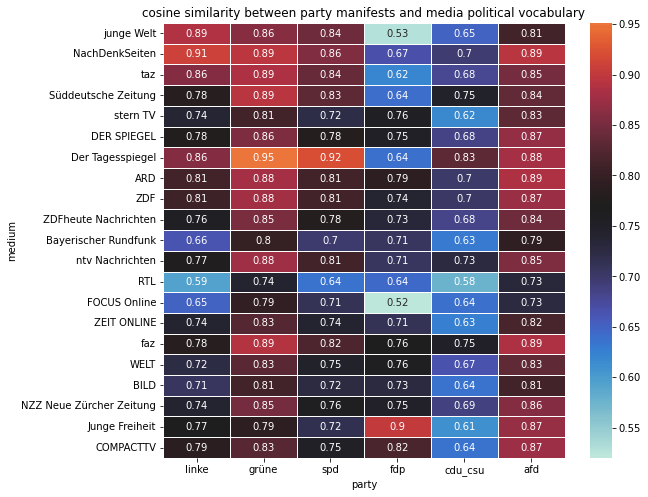

In [6]:
df_to_plot = similarity_df.drop('Tagesschau')

f, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(df_to_plot, annot=True, fmt=".2", linewidths=.5, ax=ax, center=np.nanmean(df_to_plot))
ax.set(xlabel='party', ylabel='medium', title='cosine similarity between party manifests and media political vocabulary')

In [11]:
stats_df = similarity_df.drop('Tagesschau')
print(f"cosine similarity means:\n{stats_df.mean()}\n\ncosine similarity standard deviation:\n{stats_df.std()}")

cosine similarity means:
linke      0.767305
grüne      0.847123
spd        0.776811
fdp        0.708076
cdu_csu    0.675049
afd        0.839291
dtype: float64

cosine similarity standard deviation:
linke      0.077276
grüne      0.047771
spd        0.065982
fdp        0.089743
cdu_csu    0.057586
afd        0.046280
dtype: float64


In [35]:
similarity_df.drop('Tagesschau').loc[media].to_pickle('../data/vocabulary/political.pkl')